In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

from SpaDA_main import run_SpaDA

In [2]:
adata1 = sc.read_h5ad('./data/Sagittal_Anterior_subset.h5ad')
adata1

AnnData object with n_obs × n_vars = 1078 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
adata2 = sc.read_h5ad('./data/allen_cortex.h5ad')
adata2 = adata2[adata2.obs['subclass'].isin(['Astro', 'L2/3 IT', 'L4', 'L5 IT', 'L5 PT', 'L6b', 'L6 CT', 'L6 IT', 'Oligo'])]
adata2

View of AnnData object with n_obs × n_vars = 7456 × 34617
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_id', 'sample_type', 'organism', 'donor', 'sex', 'age_days', 'eye_condition', 'genotype', 'driver_lines', 'reporter_lines', 'brain_hemisphere', 'brain_region', 'brain_subregion', 'injection_label_direction', 'injection_primary', 'injection_secondary', 'injection_tract', 'injection_material', 'injection_exclusion_criterion', 'facs_date', 'facs_container', 'facs_sort_criteria', 'rna_amplification_set', 'library_prep_set', 'library_prep_avg_size_bp', 'seq_name', 'seq_tube', 'seq_batch', 'total_reads', 'percent_exon_reads', 'percent_intron_reads', 'percent_intergenic_reads', 'percent_rrna_reads', 'percent_mt_exon_reads', 'percent_reads_unique', 'percent_synth_reads', 'percent_ecoli_reads', 'percent_aligned_reads_total', 'complexity_cg', 'genes_detected_cpm_criterion', 'genes_detected_fpkm_criterion', 'tdt_cpm', 'gfp_cpm', 'class', 'subclass', 'cluster', 'confusion_score', '

In [4]:
adata0 = adata1.concatenate(adata2)

sc.pp.highly_variable_genes(adata0, n_top_genes=3000, flavor='seurat_v3', batch_key='batch')
adata0 = adata0[:, adata0.var.highly_variable]

C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [5]:
S, Z1, Z2 = run_SpaDA(
    adata=adata0,
    n_epochs=1000,
    n_hidden=512,
    n_latent=64
)

100%|█████████████████████████████████████████████████████████████| 1000/1000 [02:43<00:00,  6.12it/s, loss: 4.476e+06]


In [6]:
S = pd.DataFrame(S, index=adata1.obs_names)
S_df = S.groupby(adata2.obs['subclass'].to_numpy(), axis=1).aggregate(np.sum)
S_df = S_df / np.sum(S_df.to_numpy(), axis=1, keepdims=True)

In [7]:
adata_plot = sc.AnnData(S_df)
adata_plot.obs_names = adata1.obs_names
adata_plot.obsm = adata1.obsm
adata_plot.uns = adata1.uns

C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.


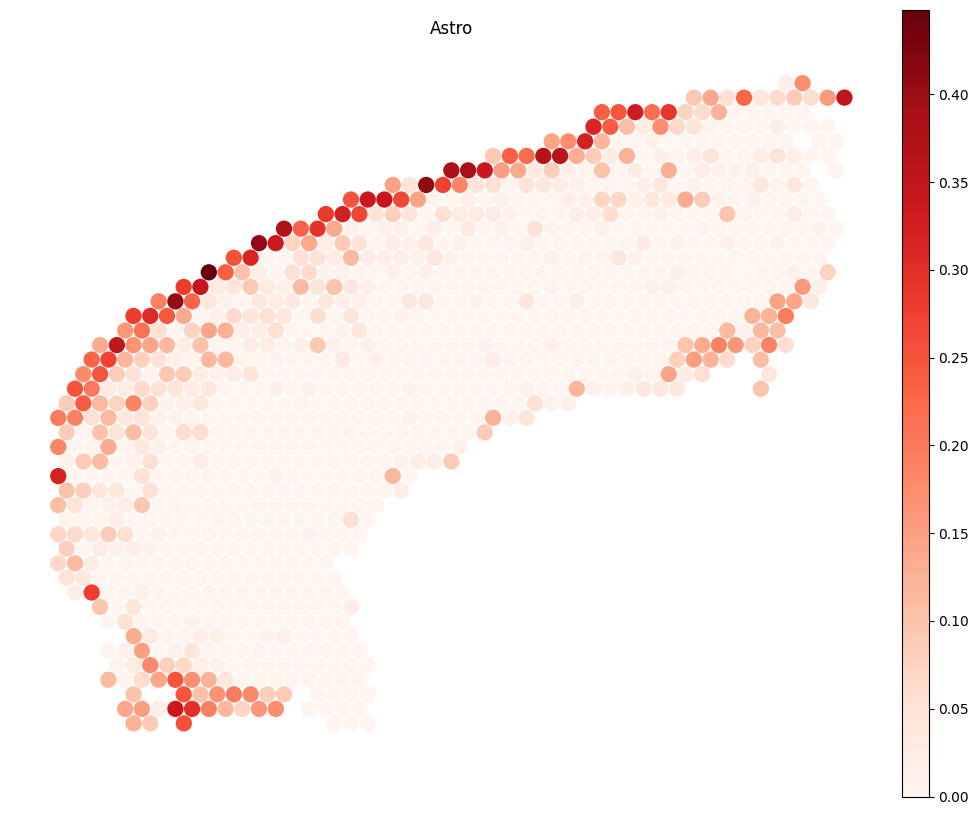

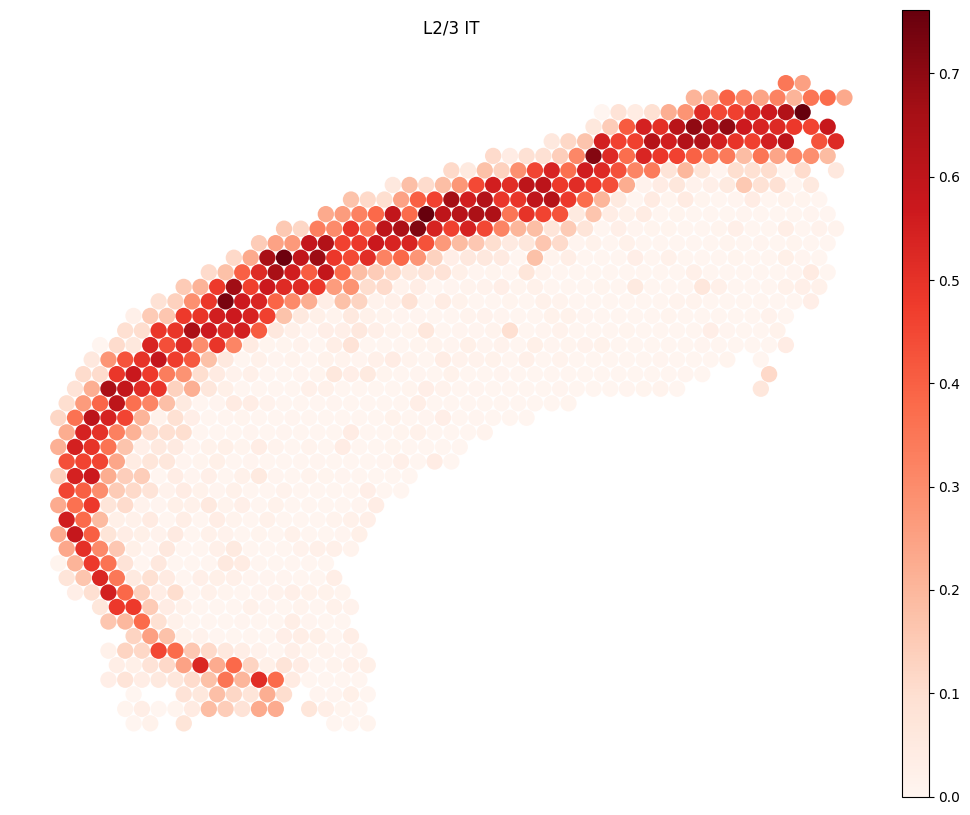

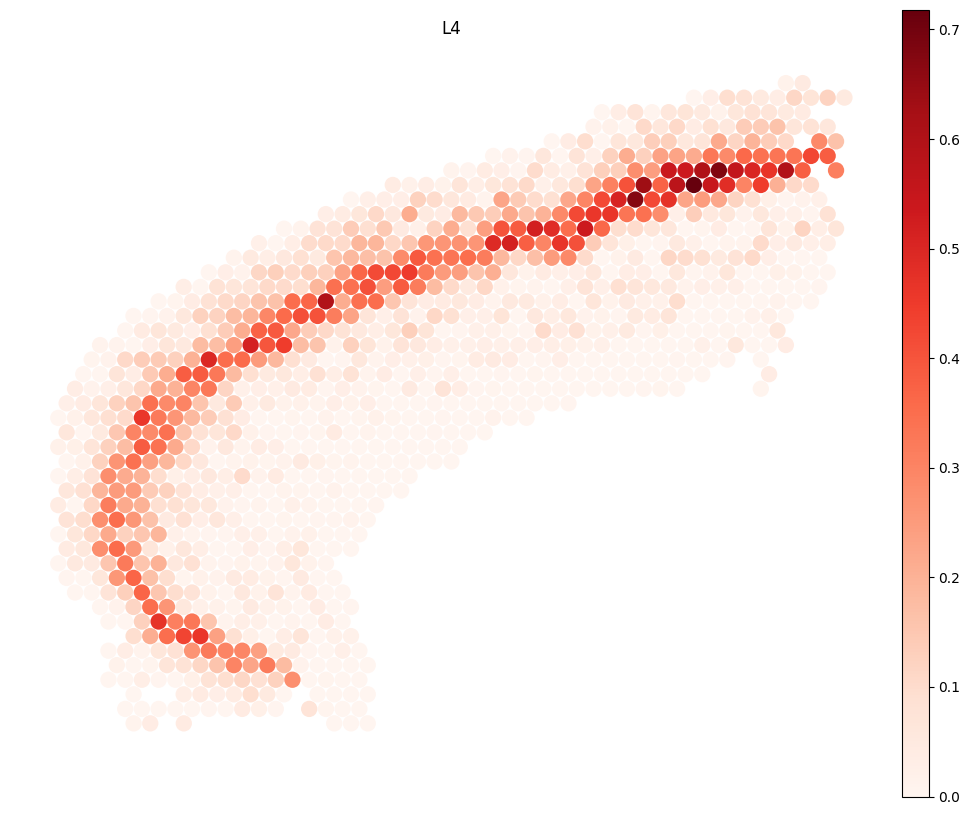

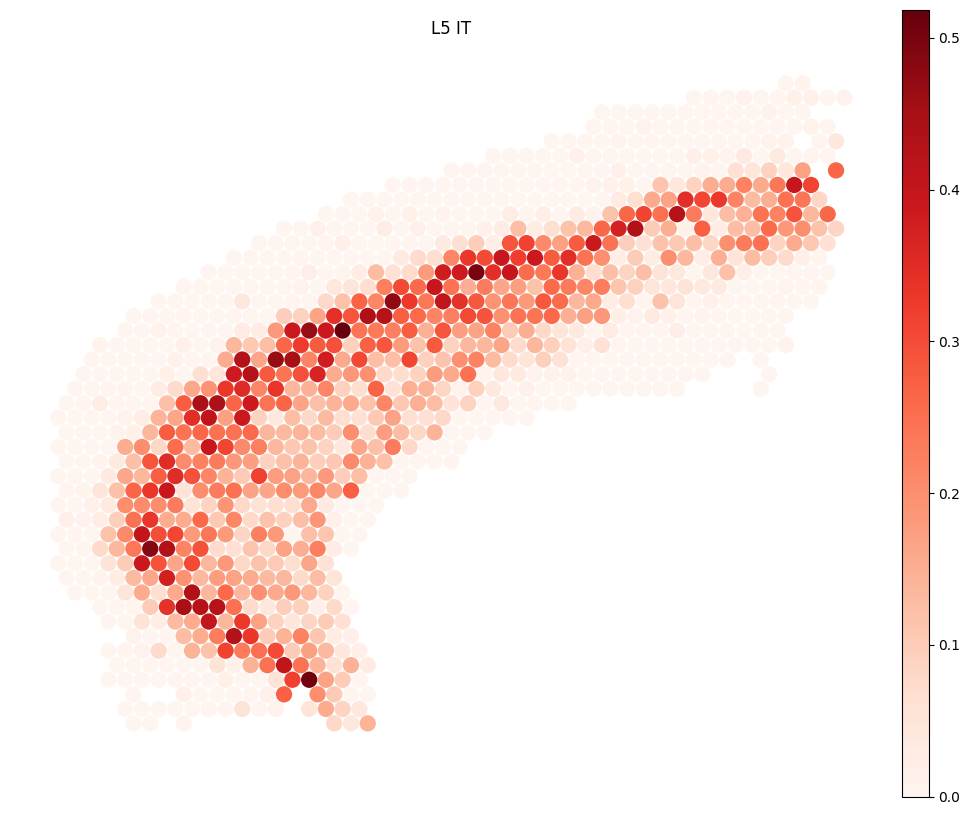

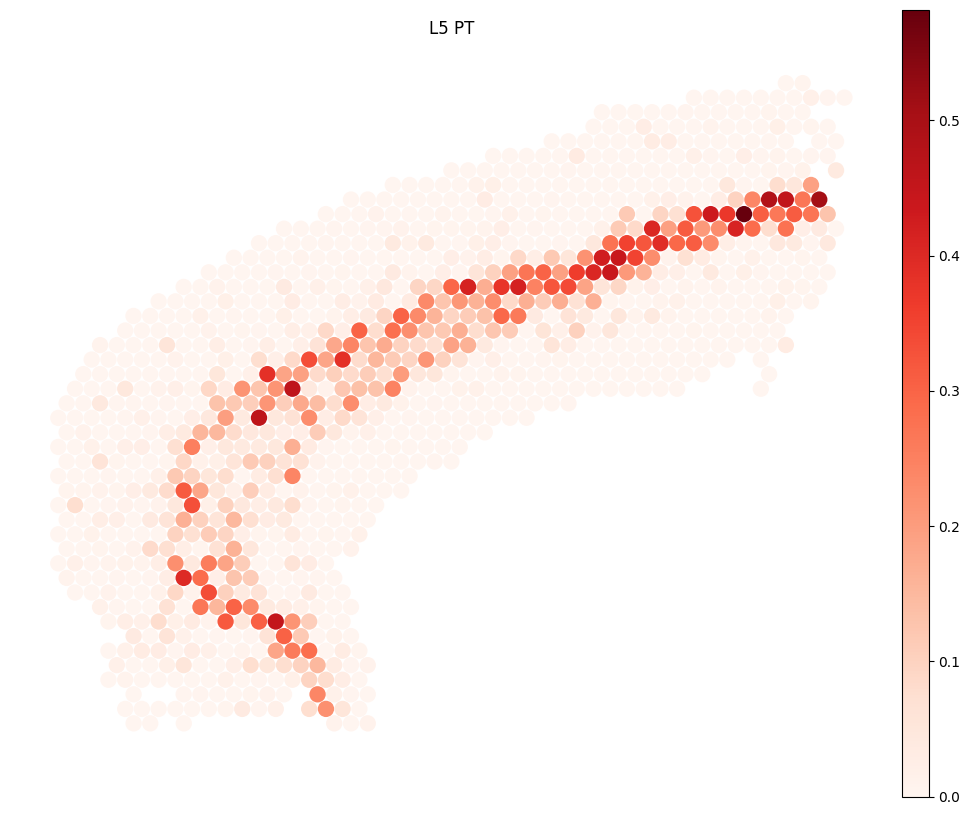

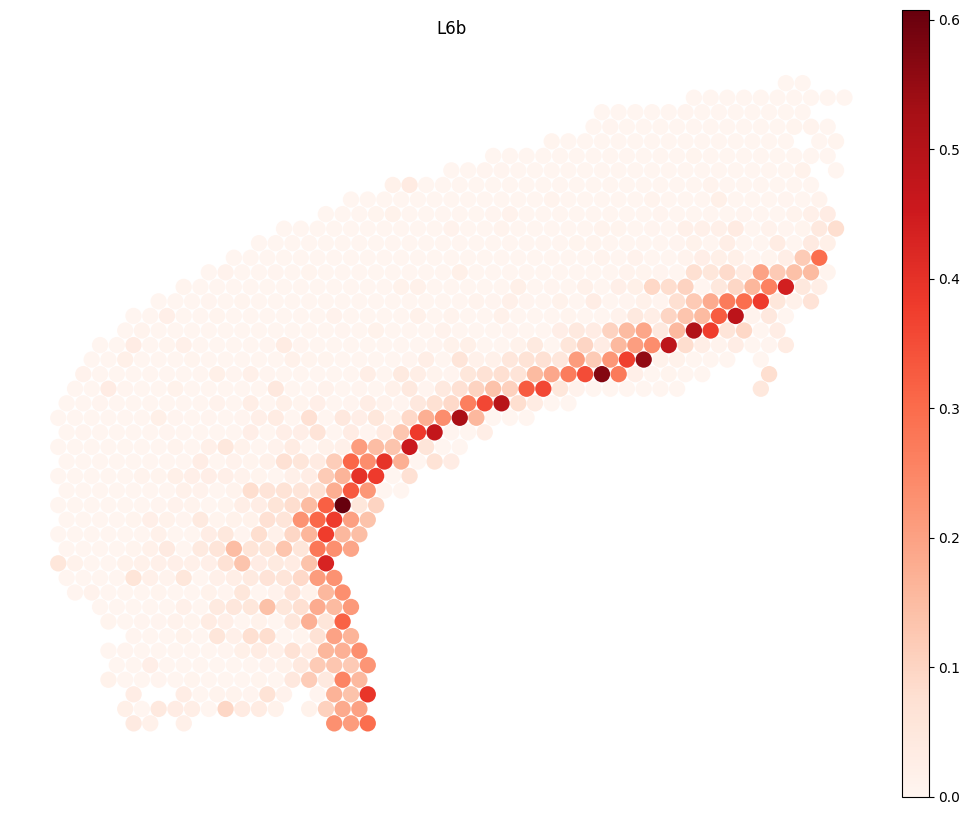

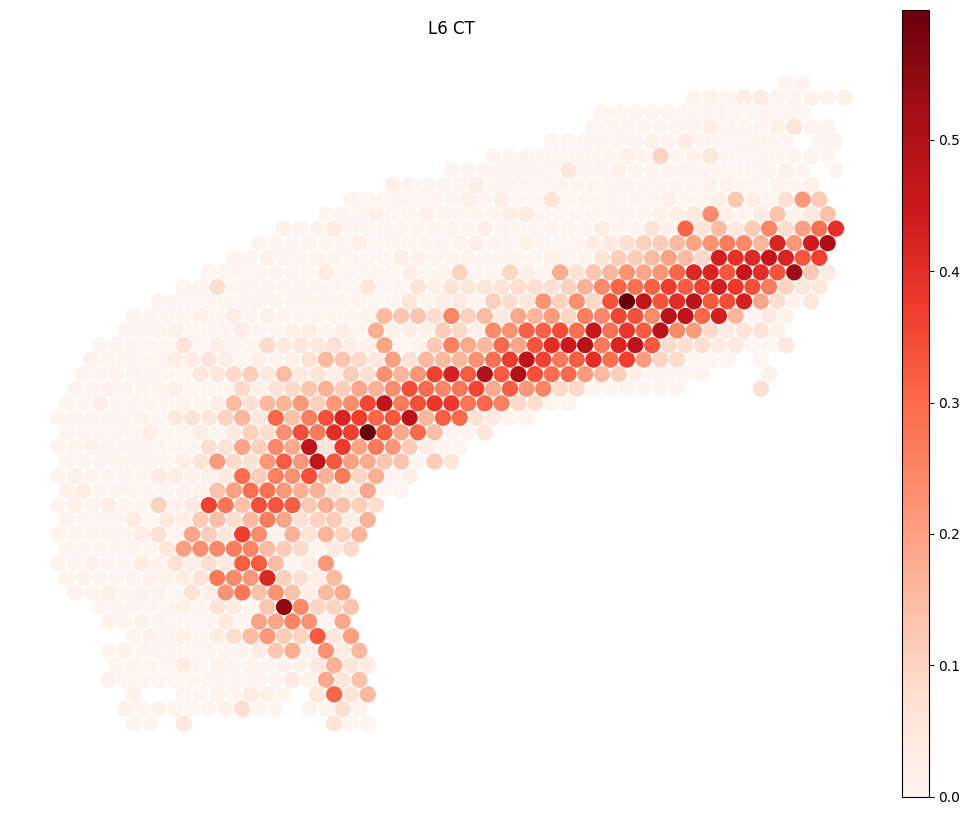

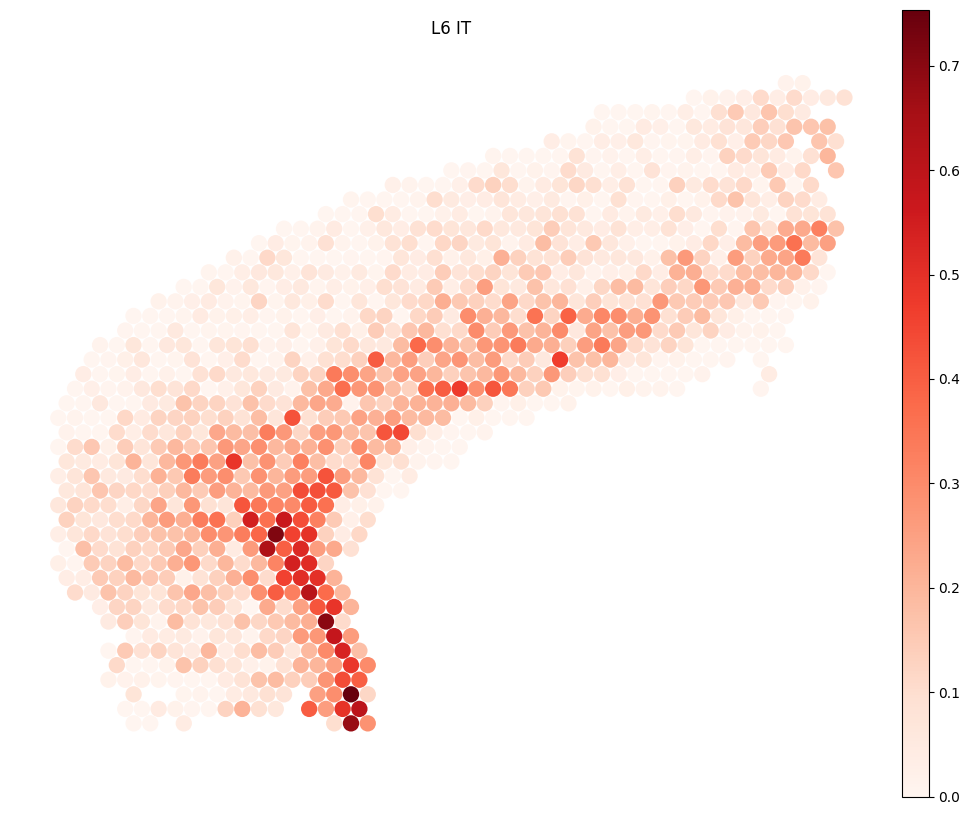

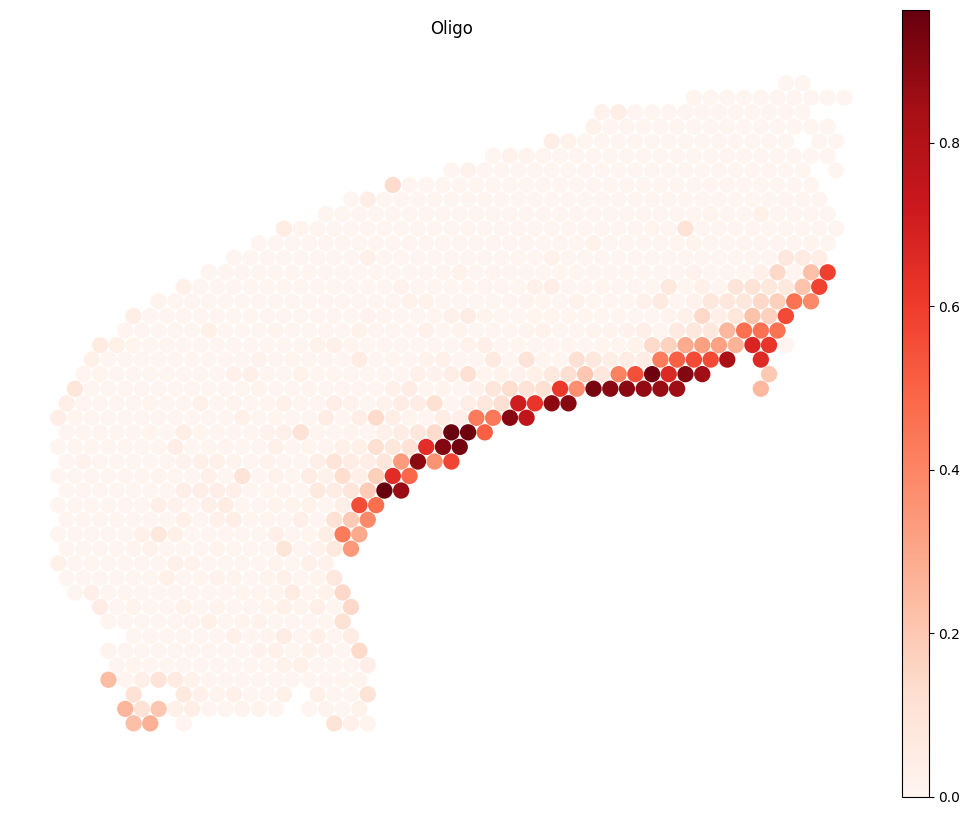

In [8]:
for celltype in ['Astro', 'L2/3 IT', 'L4', 'L5 IT', 'L5 PT', 'L6b', 'L6 CT', 'L6 IT', 'Oligo']:

    fig, axs = plt.subplots(figsize=(10, 8.25))

    sc.pl.spatial(
        adata_plot,
        img_key=None,
        color=celltype,
        size=1.5,
        color_map='Reds',
        legend_loc='right margin',
        frameon=False,
        title=celltype,
        show=False,
        ax=axs,
    )

    plt.tight_layout()